In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
flights = sns.load_dataset("flights")

In [3]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [4]:
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [5]:
flights.describe()

,year,passengers
count,144.000000,144.000000
mean,1954.500000,280.298611
std,3.464102,119.966317
min,1949.000000,104.000000
25%,1951.750000,180.000000
50%,1954.500000,265.500000
75%,1957.250000,360.500000
max,1960.000000,622.000000


In [6]:
# Long-term trend (aggregate over months)

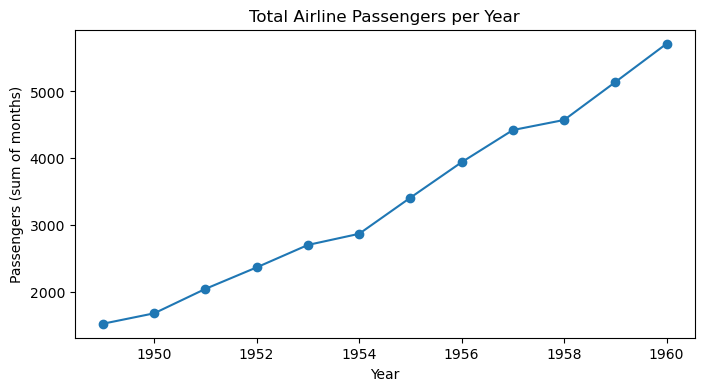

In [7]:
yearly = flights.groupby("year", as_index=False)["passengers"].sum()

plt.figure(figsize=(8,4))
plt.plot(yearly["year"], yearly["passengers"], marker="o")
plt.title("Total Airline Passengers per Year")
plt.xlabel("Year")
plt.ylabel("Passengers (sum of months)")
plt.show()

In [8]:
# Monthly seasonality (average pattern)

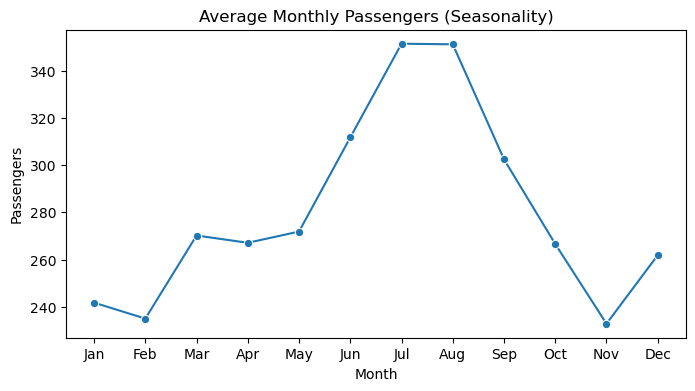

In [9]:
monthly_avg = flights.groupby("month", as_index=False, observed=True)["passengers"].mean()

plt.figure(figsize=(8,4))
sns.lineplot(data=monthly_avg, x="month", y="passengers", marker="o")
plt.title("Average Monthly Passengers (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.show()

In [10]:
# Year × Month heatmap

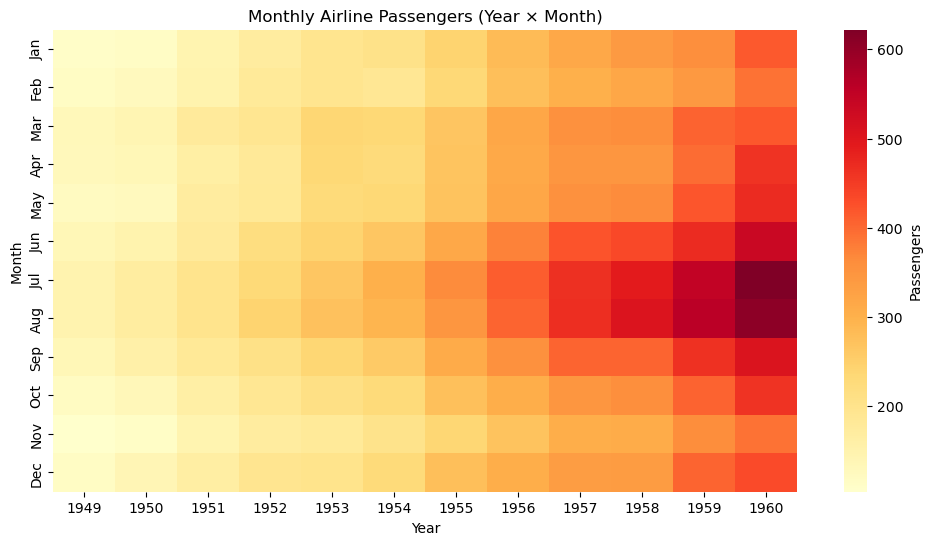

In [11]:
pivot = flights.pivot(index="month", columns="year", values="passengers")

plt.figure(figsize=(12,6))
sns.heatmap(
    pivot,
    cmap="YlOrRd",
    cbar_kws={"label": "Passengers"}
)
plt.title("Monthly Airline Passengers (Year × Month)")
plt.xlabel("Year")
plt.ylabel("Month")
plt.show()

In [12]:
# Seasonality amplitude over time

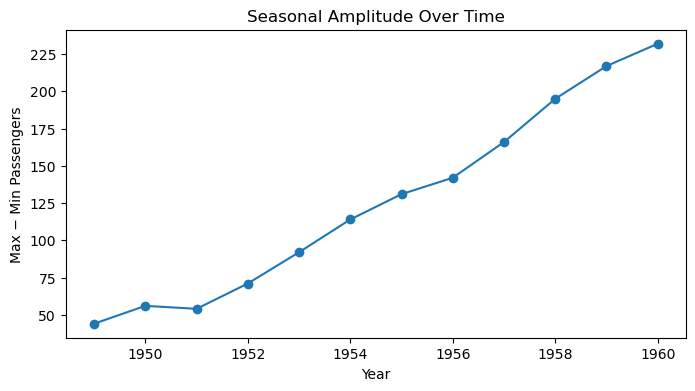

In [13]:
season_amp = (
    flights
    .groupby("year")["passengers"]
    .agg(lambda x: x.max() - x.min())
    .reset_index(name="seasonal_amplitude")
)

plt.figure(figsize=(8,4))
plt.plot(season_amp["year"], season_amp["seasonal_amplitude"], marker="o")
plt.title("Seasonal Amplitude Over Time")
plt.xlabel("Year")
plt.ylabel("Max − Min Passengers")
plt.show()

In [14]:
# Log transform (stabilizing variance)

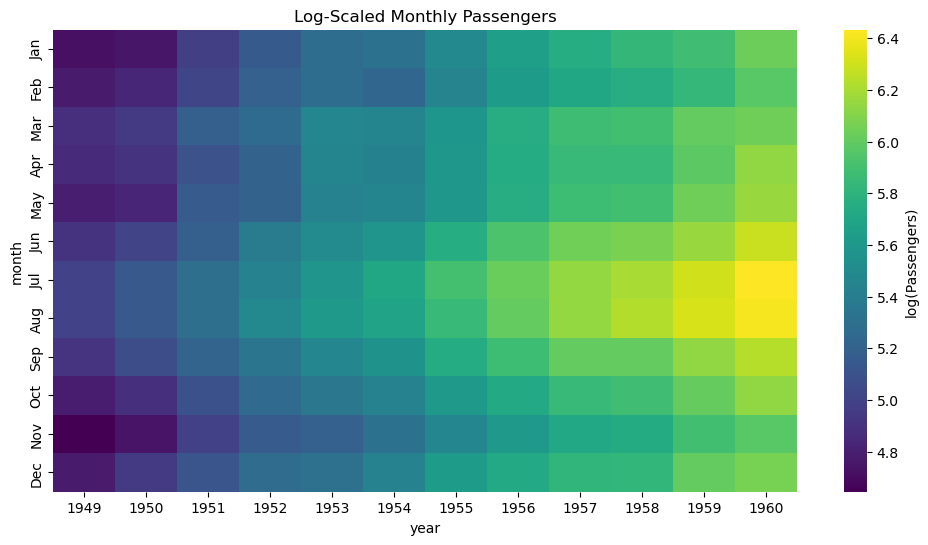

In [15]:
flights["log_passengers"] = np.log(flights["passengers"])

pivot_log = flights.pivot(index="month", columns="year", values="log_passengers")

plt.figure(figsize=(12,6))
sns.heatmap(
    pivot_log,
    cmap="viridis",
    cbar_kws={"label": "log(Passengers)"}
)
plt.title("Log-Scaled Monthly Passengers")
plt.show()

In [16]:
# Year-over-year growth rates

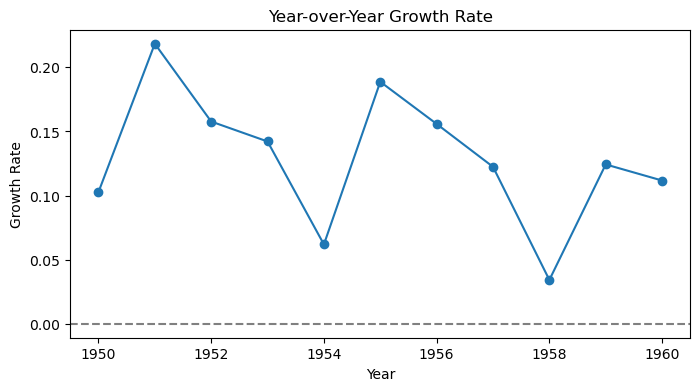

In [17]:
yearly["yoy_growth"] = yearly["passengers"].pct_change()

plt.figure(figsize=(8,4))
plt.plot(yearly["year"], yearly["yoy_growth"], marker="o")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Year-over-Year Growth Rate")
plt.xlabel("Year")
plt.ylabel("Growth Rate")
plt.show()

#### Airline passenger traffic exhibits strong long-term growth combined with stable, repeating seasonal patterns. 

#### Seasonal fluctuations increase in absolute magnitude as total volume grows, indicating multiplicative seasonality and heteroskedastic variance. 

#### Unlike purely trending macro datasets, the Flights data demonstrates interpretable temporal structure where both trend and seasonality carry meaningful signal rather than spurious correlation.

In [18]:
# Month-Specific Growth Rates

In [19]:
fl = flights.sort_values(["month", "year"]).copy()

fl["yoy_growth"] = (
    fl.groupby("month", observed=True)["passengers"]
      .pct_change()
)

In [20]:
month_growth = (
    fl.groupby("month", as_index=False, observed=True)["yoy_growth"]
      .mean()
)

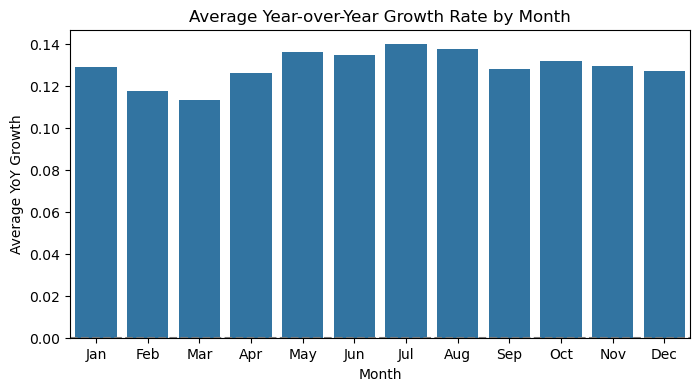

In [21]:
plt.figure(figsize=(8,4))
sns.barplot(data=month_growth, x="month", y="yoy_growth")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Average Year-over-Year Growth Rate by Month")
plt.ylabel("Average YoY Growth")
plt.xlabel("Month")
plt.show()

In [22]:
# Variability of growth by month

In [23]:
month_growth_stats = (
    fl.groupby("month", observed=True)["yoy_growth"]
      .agg(["mean", "std"])
      .reset_index()
)

month_growth_stats

,month,mean,std
0,Jan,0.129044,0.072352
1,Feb,0.117856,0.082177
2,Mar,0.113664,0.085429
3,Apr,0.126467,0.095431
4,May,0.136142,0.107539
5,Jun,0.134756,0.059055
6,Jul,0.139968,0.036735
7,Aug,0.137582,0.046329
8,Sep,0.128428,0.052476
9,Oct,0.132088,0.051609


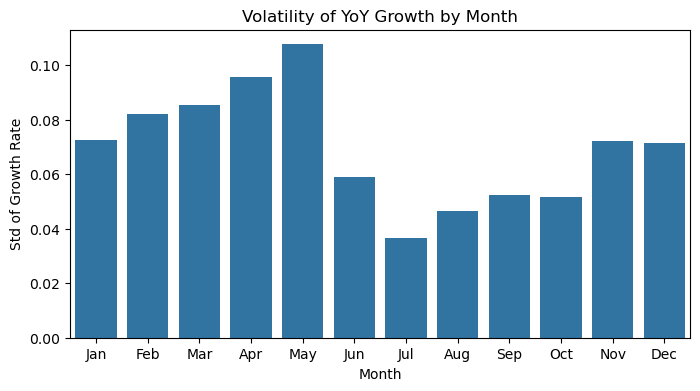

In [24]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=month_growth_stats,
    x="month",
    y="std"
)
plt.title("Volatility of YoY Growth by Month")
plt.ylabel("Std of Growth Rate")
plt.xlabel("Month")
plt.show()

In [25]:
# Heatmap: growth by year × month

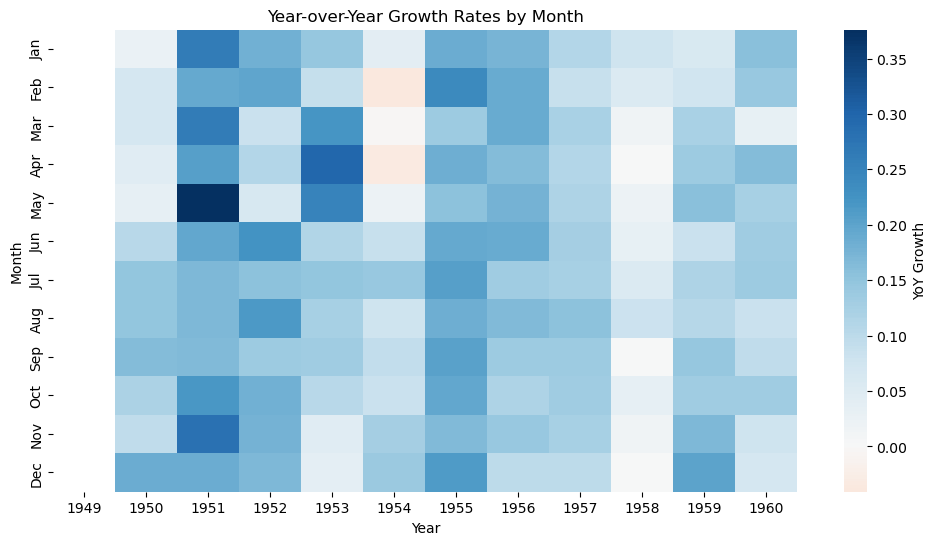

In [26]:
growth_pivot = fl.pivot(
    index="month",
    columns="year",
    values="yoy_growth"
)

plt.figure(figsize=(12,6))
sns.heatmap(
    growth_pivot,
    cmap="RdBu",
    center=0,
    cbar_kws={"label": "YoY Growth"}
)
plt.title("Year-over-Year Growth Rates by Month")
plt.xlabel("Year")
plt.ylabel("Month")
plt.show()

#### Month-specific growth analysis shows that airline passenger growth was positive across all months, with only modest seasonal differences. 

#### While summer months exhibit slightly higher and more volatile growth, the long-term expansion of air travel reflects a system-wide increase in demand rather than growth driven by any particular season.

In [27]:
# Seasonal Indices & Seasonality Type

In [28]:
fl = flights.copy()

# Yearly mean passengers
fl["year_mean"] = fl.groupby("year")["passengers"].transform("mean")

# Seasonal index
fl["seasonal_index"] = fl["passengers"] / fl["year_mean"]

In [29]:
seasonal_idx = (
    fl.groupby("month", as_index=False, observed=True)["seasonal_index"]
      .mean()
)
seasonal_idx

,month,seasonal_index
0,Jan,0.861134
1,Feb,0.851871
2,Mar,0.979998
3,Apr,0.958966
4,May,0.966231
5,Jun,1.102620
6,Jul,1.236360
7,Aug,1.237095
8,Sep,1.080781
9,Oct,0.950753


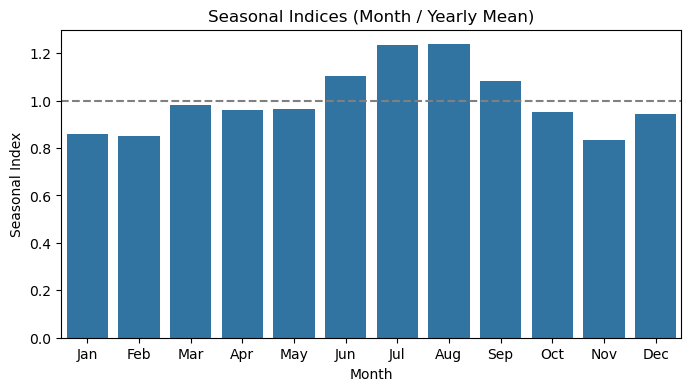

In [30]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=seasonal_idx,
    x="month",
    y="seasonal_index"
)
plt.axhline(1, color="gray", linestyle="--")
plt.title("Seasonal Indices (Month / Yearly Mean)")
plt.ylabel("Seasonal Index")
plt.xlabel("Month")
plt.show()

In [31]:
# Additive seasonality test

In [32]:
fl["additive_season"] = fl["passengers"] - fl["year_mean"]

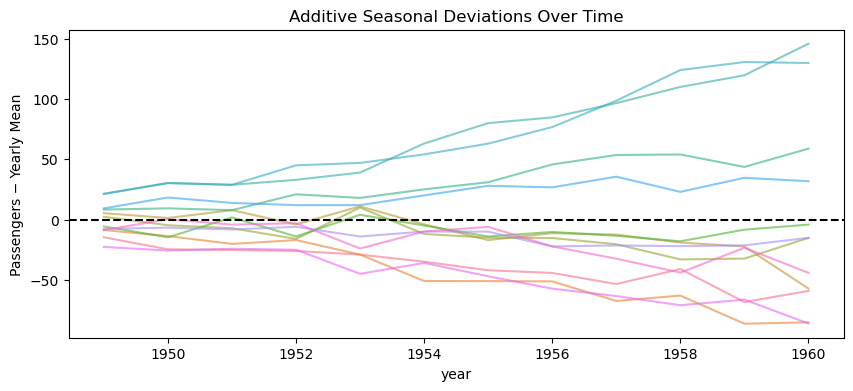

In [33]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=fl,
    x="year",
    y="additive_season",
    hue="month",
    legend=False,
    alpha=0.6
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Additive Seasonal Deviations Over Time")
plt.ylabel("Passengers − Yearly Mean")
plt.show()

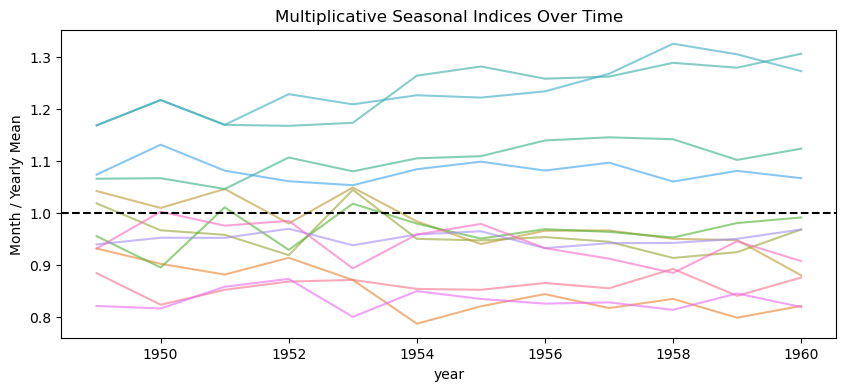

In [34]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=fl,
    x="year",
    y="seasonal_index",
    hue="month",
    legend=False,
    alpha=0.6
)
plt.axhline(1, color="black", linestyle="--")
plt.title("Multiplicative Seasonal Indices Over Time")
plt.ylabel("Month / Yearly Mean")
plt.show()

In [35]:
# Log-scale confirmation

In [36]:
fl["log_passengers"] = np.log(fl["passengers"])
fl["log_year_mean"] = np.log(fl["year_mean"])
fl["log_season"] = fl["log_passengers"] - fl["log_year_mean"]

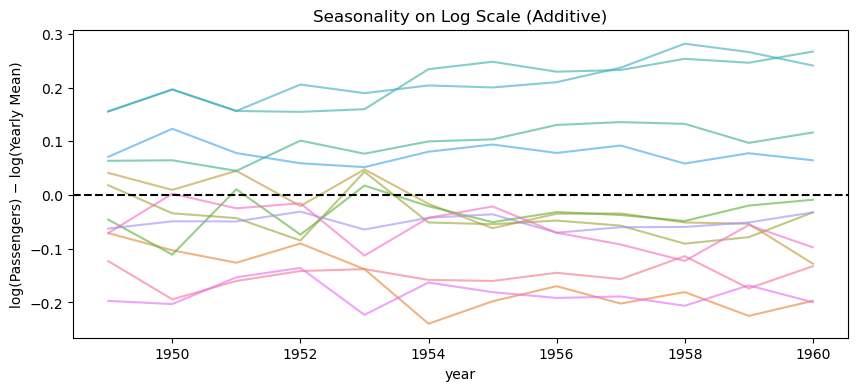

In [37]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=fl,
    x="year",
    y="log_season",
    hue="month",
    legend=False,
    alpha=0.6
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Seasonality on Log Scale (Additive)")
plt.ylabel("log(Passengers) − log(Yearly Mean)")
plt.show()

#### Seasonal indices show that airline passenger seasonality is stable in relative terms across years. 

#### While absolute seasonal deviations increase with overall traffic volume, month-to-year ratios remain nearly constant, providing strong visual evidence for multiplicative seasonality. 

#### This structure explains the observed heteroskedasticity and validates log-based transformations for analyzing long-term trends.